In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from pylab import mpl, plt
import time
from sklearn.metrics import mean_squared_error


<AxesSubplot: xlabel='Date'>

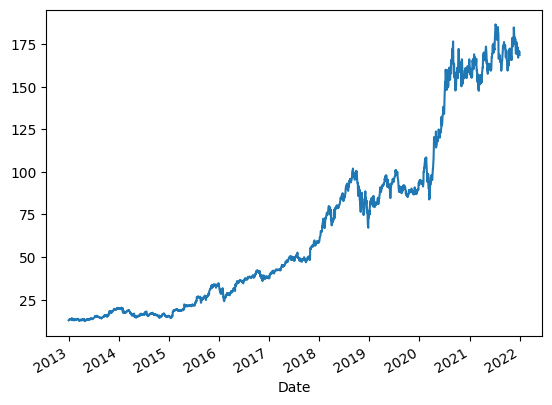

In [17]:


AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
dataset.head(10)
dataset['Close'].plot()


In [18]:
dataset_close=dataset['Close']
dataset_close.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2266 entries, 2013-01-02 to 2021-12-30
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2266 non-null   float64
dtypes: float64(1)
memory usage: 35.4 KB


In [19]:

sc = MinMaxScaler(feature_range=(0,1))
dataset_train_scaled = sc.fit_transform(dataset_close.values.reshape(-1,1))

In [20]:

dataset_scaled = np.array(dataset_train_scaled)

data = []
time_step = 100
# create all possible sequences of length look_back
for index in range(len(dataset_scaled) - time_step): 
    data.append(dataset_scaled[index: index + time_step])

data = np.array(data)
# test_timestamps = np.array(test_timestamps)

test_size = int(np.round(0.2*data.shape[0]))
train_size = data.shape[0] - (test_size)
print(test_size)

X_train = data[:train_size,:-1,:]
y_train = data[:train_size,-1,:]

X_test = data[train_size:,:-1]
y_test = data[train_size:,-1,:]

# scale
# X_train = sc.fit_transform(X_train.reshape(-1,1))
# y_train = sc.fit_transform(y_train.reshape(-1,1))

# X_test = sc.fit_transform(X_test.reshape(-1,1))
# y_test = sc.fit_transform(y_test.reshape(-1,1))

433


In [88]:
dataset_close[len(dataset_close)- len(y_test):].index

DatetimeIndex(['2020-04-15', '2020-04-16', '2020-04-17', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-27', '2020-04-28',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=433, freq=None)

In [89]:
train_size

1733

In [ ]:
# X_train = []
# y_train = []
# y_train_stacked = []
# data_len = len(dataset_train_scaled)
# data_len_test = len(dataset_test_scaled)
# input_steps = 5
# op_steps = 2

# for i in range(input_steps, data_len-1): 
#     X_train.append(dataset_train_scaled[i-input_steps : i, 0])
#     y_train.append(dataset_train_scaled[i : i+op_steps, 0])

# X_train, y_train = np.array(X_train), np.array(y_train)

# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# X_test = []
# y_test = []
# for i in range(input_steps, data_len_test-1): 
#     X_test.append(dataset_test_scaled[i-input_steps : i, 0])
#     y_test.append(dataset_test_scaled[i : i+op_steps, 0])

# X_test, y_test = np.array(X_test), np.array(y_test)

# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [90]:
len(y_train)

1733

In [ ]:
# y_train.size(),X_train.size()


In [21]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)


X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batch_size = 24
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [ ]:
y_train.size(),X_train.size()


In [80]:
# deep rnn

class Vanilla_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Vanilla_RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # RNN layers
        self.rnn = nn.RNN(input_dim, hidden_dim)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        # print(x.size(0))
        # print(x.size(1))

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(1, x.size(1), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())
        # print(out.shape)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[-1, :, :]
        # print(out.shape)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        # print(out.shape)

        # out = out.view(-1, self.output_dim)

        return out
        #     def forward(self, x):
        # x = x.permute(1, 0, 2)
        # # print(x.size(0))
        # # print(x.size(1))

        # # Initializing hidden state for first input with zeros
        # h0 = torch.zeros(1, x.size(1), self.hidden_dim).requires_grad_()

        # # Forward propagation by passing in the input and hidden state into the model
        # out, h0 = self.rnn(x, h0.detach())
        # print(out.shape)
        # # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # # so that it can fit into the fully connected layer
        # out = out[-1, :, :]
        # print(out.shape)

        # # Convert the final state to our desired output shape (batch_size, output_dim)
        # out = self.fc(out)
        # print(out.shape)

        # # out = out.view(-1, self.output_dim)

        # return out

In [23]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [78]:
class RNN_bi(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_bi, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [74]:
class LSTM_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_v2, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True,)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [92]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [22]:
class GRU_bi(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU_bi, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers *2 , x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [23]:
def fit(num_epochs, train_dl, model, criterion, optimiser):

    hist = np.zeros(num_epochs)
    start_time = time.time()

    for t in range(num_epochs):
        losses = []
        for x,y in train_dl:
            # print(x.shape)
            y_train_pred = model(x)
            loss = criterion(y_train_pred, y)
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        hist[t] = np.mean(losses)
        print("Epoch ", t, "MSE: ", hist[t])
    
    print("Training time: {}".format(time.time()-start_time))
    return hist


In [25]:
def evaluate(model, dataset_close, X_test, y_test):
    
    y_test_pred = model(X_test)

    # print(y_test_pred.shape)
    # print(y_test.shape)
    loss = torch.nn.MSELoss(reduction='mean')
    mse_loss =  loss(y_test_pred, y_test)

    print("Test loss {}".format(mse_loss))


    pred = (y_test_pred.detach().numpy())
    # pred = sc.inverse_transform(y_test_pred.detach().numpy())
    target = (y_test.detach().numpy())
    # target = sc.inverse_transform(y_test.detach().numpy())

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()

    axes.plot( dataset_close[len(dataset_close)-len(y_test):].index, target, color = 'red', label = 'Real AMZN Stock Price')
    axes.plot( dataset_close[len(dataset_close)-len(y_test):].index, pred, color = 'blue', label = 'Predicted AMZN Stock Price')

    plt.title('AMZN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMZN Stock Price')
    plt.legend()
    plt.savefig('AMZN_lstm.png')
    plt.show()

Epoch  0 MSE:  0.031001716986984798
Epoch  1 MSE:  0.00665749580366537
Epoch  2 MSE:  0.000630139286697254
Epoch  3 MSE:  0.0004685661624534987
Epoch  4 MSE:  0.00037550446761183833
Epoch  5 MSE:  0.0002747262991952563
Epoch  6 MSE:  0.00023337524908129126
Epoch  7 MSE:  0.000194111455608723
Epoch  8 MSE:  0.00018332940051454658
Epoch  9 MSE:  0.00016046113432821585
Training time: 0.3227672576904297


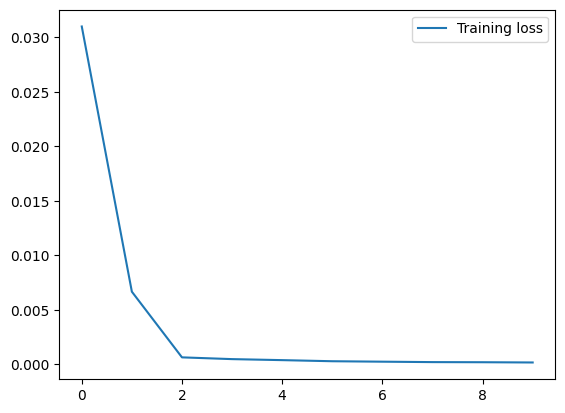

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.008969619870185852


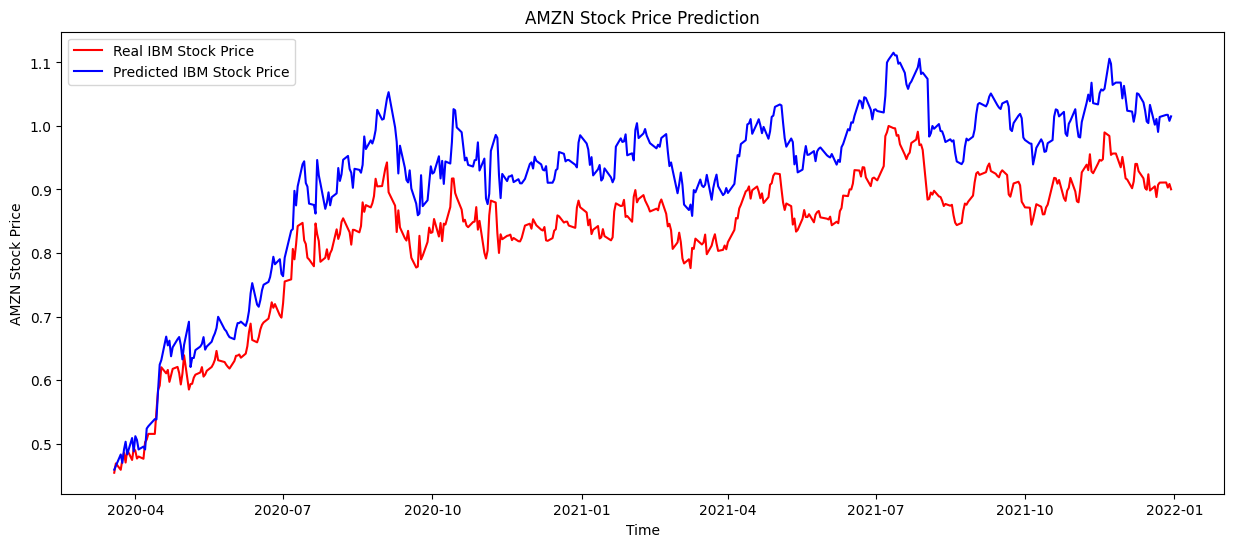

In [42]:
# vanilla lstm 1 hidd
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 10

model = Vanilla_RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)


In [81]:
# vanilla lstm 32 hidd

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = Vanilla_RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)




Epoch  0 MSE:  0.0027926914097071475
Epoch  1 MSE:  8.569825312358597e-05
Epoch  2 MSE:  8.279274870322919e-05
Epoch  3 MSE:  7.438065072643727e-05
Epoch  4 MSE:  7.239030956521961e-05
Epoch  5 MSE:  6.200673674297114e-05
Epoch  6 MSE:  5.845373399145166e-05
Epoch  7 MSE:  5.35838244762712e-05
Epoch  8 MSE:  5.7117792416169034e-05
Epoch  9 MSE:  6.321523018844968e-05
Training time: 0.378690242767334


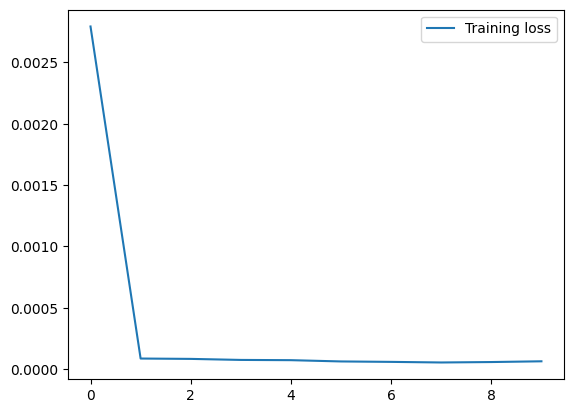

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.0008564151357859373


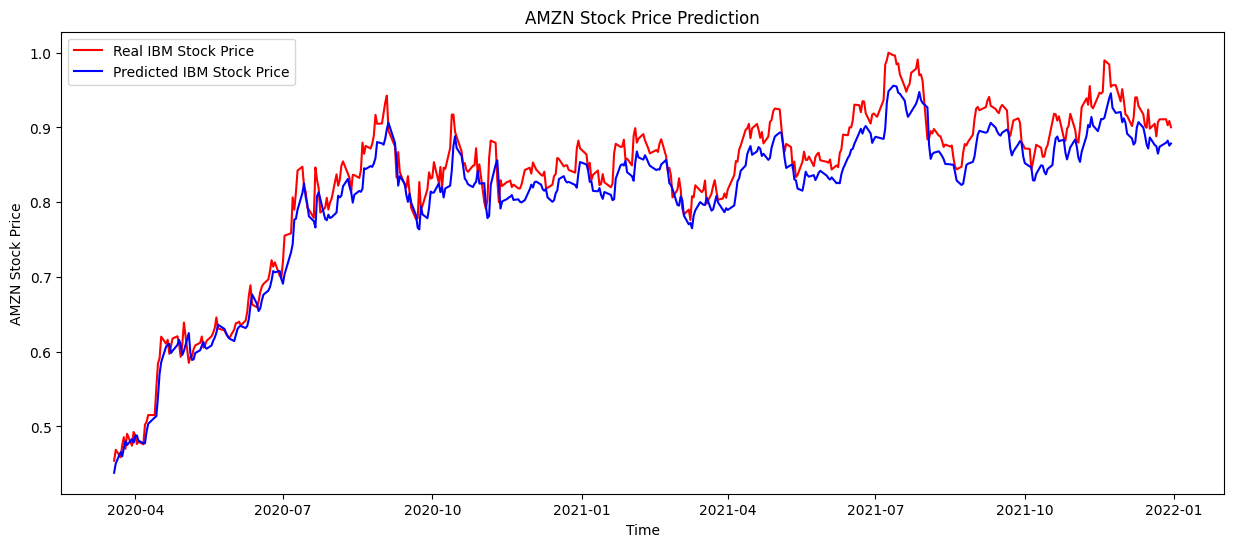

In [82]:
hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.00972605797534542
Epoch  1 MSE:  7.681419266478578e-05
Epoch  2 MSE:  6.801832932978868e-05
Epoch  3 MSE:  7.263353075502796e-05
Epoch  4 MSE:  6.106282070935489e-05
Epoch  5 MSE:  0.00013202604174311042
Epoch  6 MSE:  8.799068778467987e-05
Epoch  7 MSE:  7.260989501015789e-05
Epoch  8 MSE:  7.835176001878465e-05
Epoch  9 MSE:  7.70832378556837e-05
Training time: 0.6471309661865234


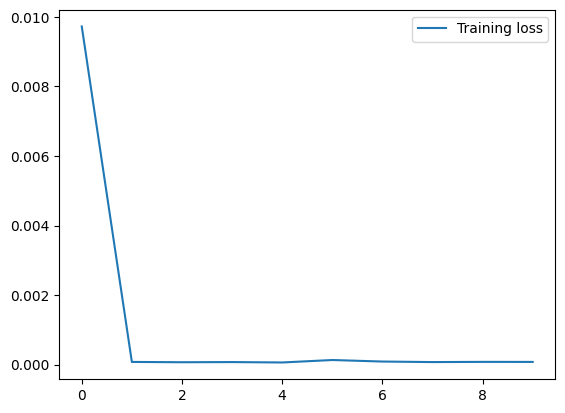

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.008382583037018776


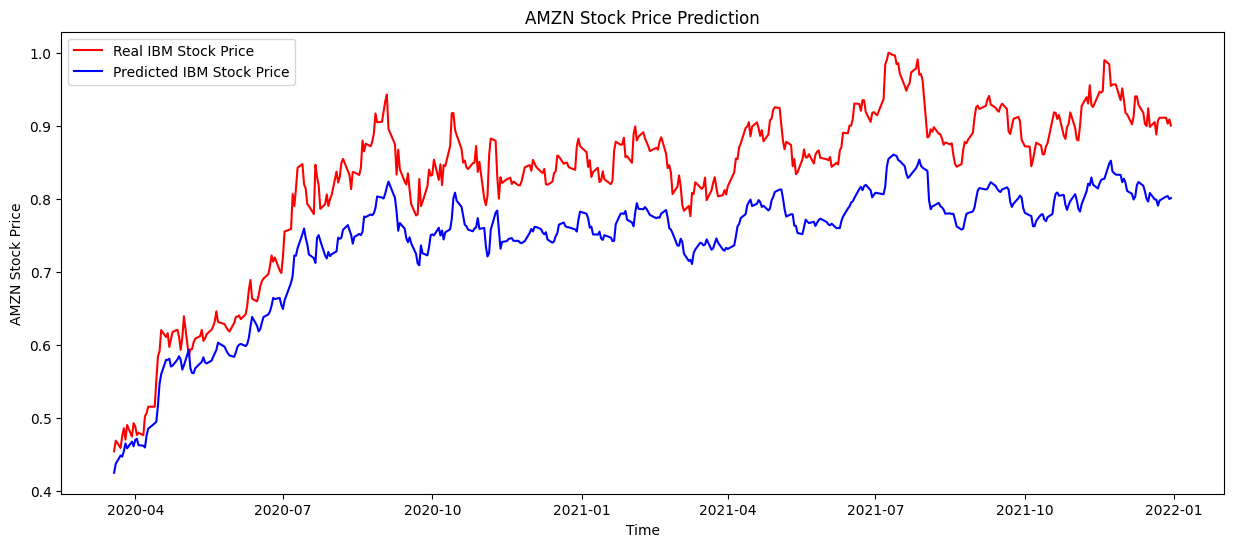

In [30]:
# stacked rnn
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.011938109692939753
Epoch  1 MSE:  0.00017136693656395532
Epoch  2 MSE:  0.00018063494778624247
Epoch  3 MSE:  0.00021972209407594115
Epoch  4 MSE:  8.602379813582e-05
Epoch  5 MSE:  8.95299450396698e-05
Epoch  6 MSE:  0.00010645300696858995
Epoch  7 MSE:  0.00024234205990356523
Epoch  8 MSE:  6.407597489717438e-05
Epoch  9 MSE:  0.00011206746524438036
Training time: 1.1340088844299316


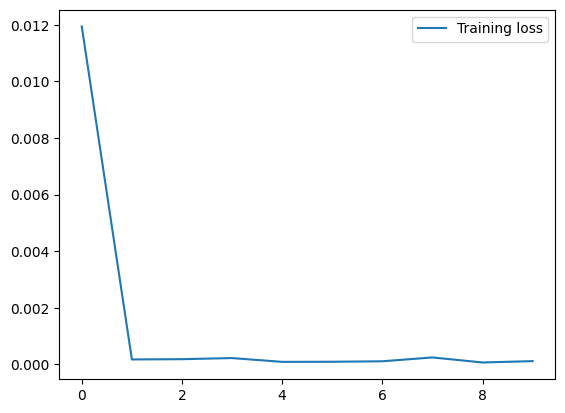

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.019759902730584145


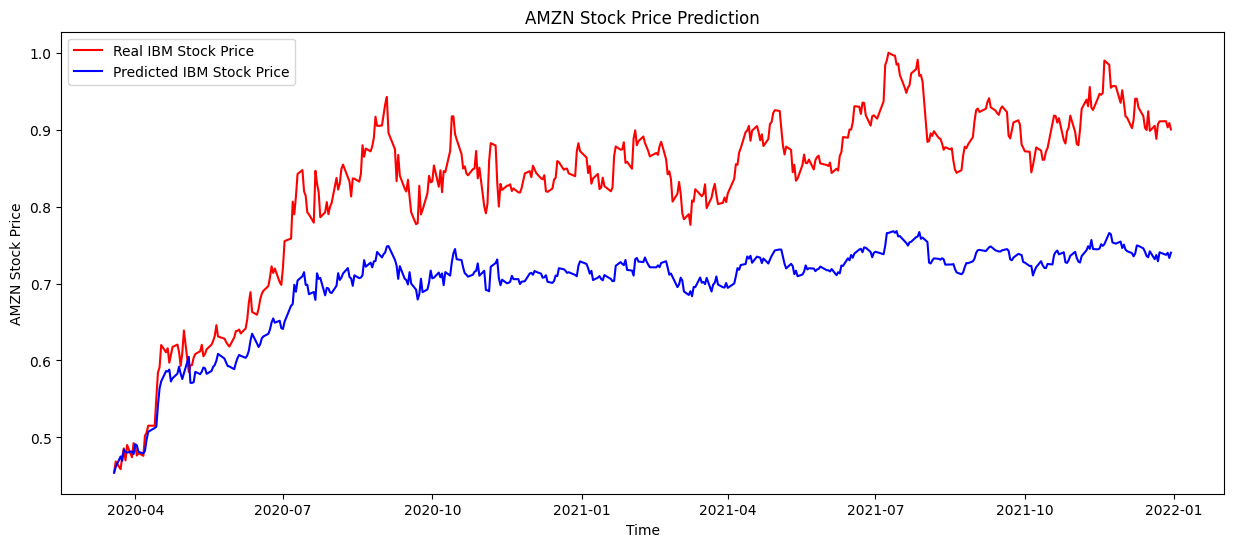

In [28]:
# stacked rnnn
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 10

model = RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.011383670842836804
Epoch  1 MSE:  5.668756400729379e-05
Epoch  2 MSE:  4.725949841150922e-05
Epoch  3 MSE:  4.483097758996959e-05
Epoch  4 MSE:  5.225663783161699e-05
Epoch  5 MSE:  6.178822514500912e-05
Epoch  6 MSE:  5.2415021310767575e-05
Epoch  7 MSE:  5.6687482936611465e-05
Epoch  8 MSE:  5.192646181297421e-05
Epoch  9 MSE:  7.83014141617107e-05
Training time: 1.1794161796569824


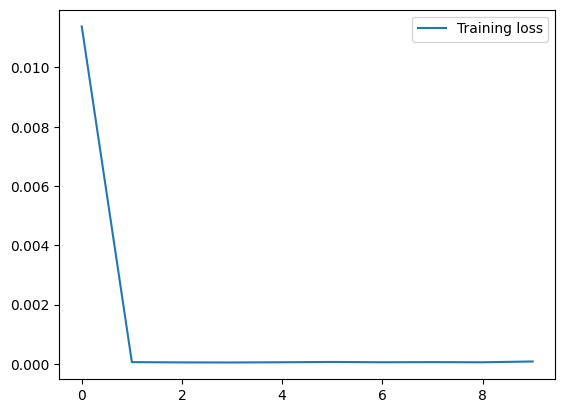

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.0029155458323657513


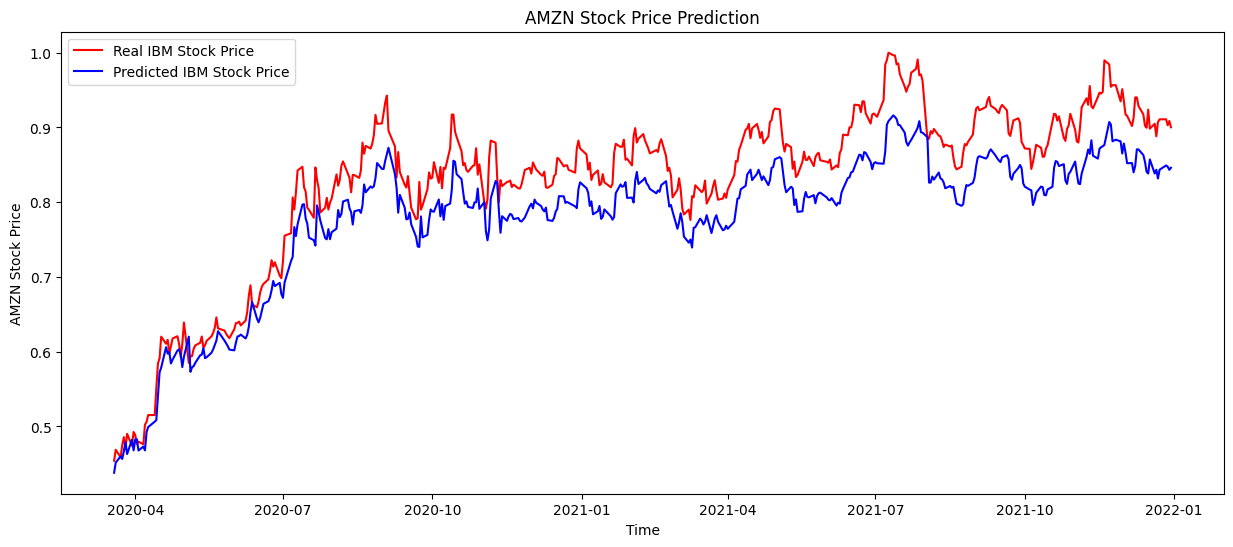

In [79]:
# bi directional rnn
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = RNN_bi(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.016875625998517007
Epoch  1 MSE:  0.0014779970956384971
Epoch  2 MSE:  8.432444191815816e-05
Epoch  3 MSE:  8.076667360288219e-05
Epoch  4 MSE:  7.00952214892344e-05
Epoch  5 MSE:  6.991477587354511e-05
Epoch  6 MSE:  7.067811298168778e-05
Epoch  7 MSE:  7.1976394230277e-05
Epoch  8 MSE:  6.76000378653522e-05
Epoch  9 MSE:  6.609944959659755e-05
Training time: 0.5394570827484131


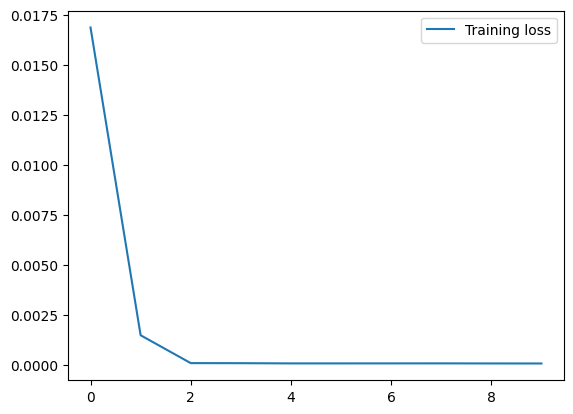

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.02796153351664543


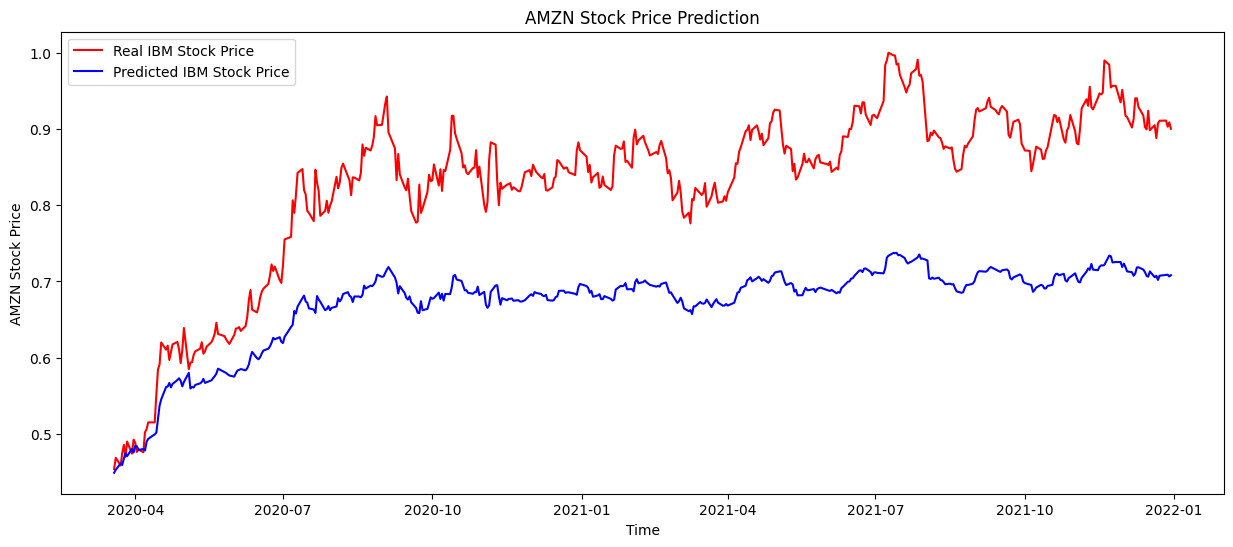

In [33]:
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.007280041740350977
Epoch  1 MSE:  8.858533815806655e-05
Epoch  2 MSE:  8.248383282032017e-05
Epoch  3 MSE:  7.110438730849542e-05
Epoch  4 MSE:  7.342209281839467e-05
Epoch  5 MSE:  7.289368692765588e-05
Epoch  6 MSE:  8.547262882530049e-05
Epoch  7 MSE:  9.07970522025368e-05
Epoch  8 MSE:  7.327057344235455e-05
Epoch  9 MSE:  9.886091810298432e-05
Training time: 0.7515628337860107


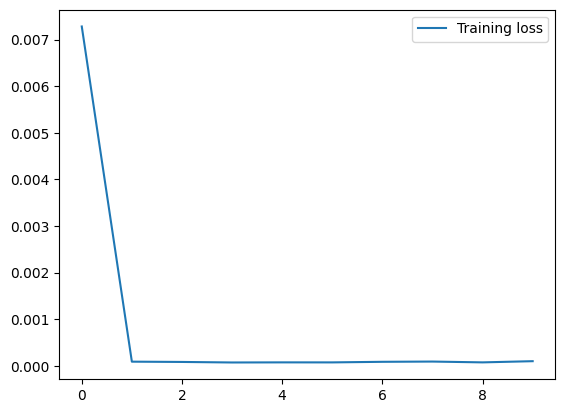

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.0038635488599538803


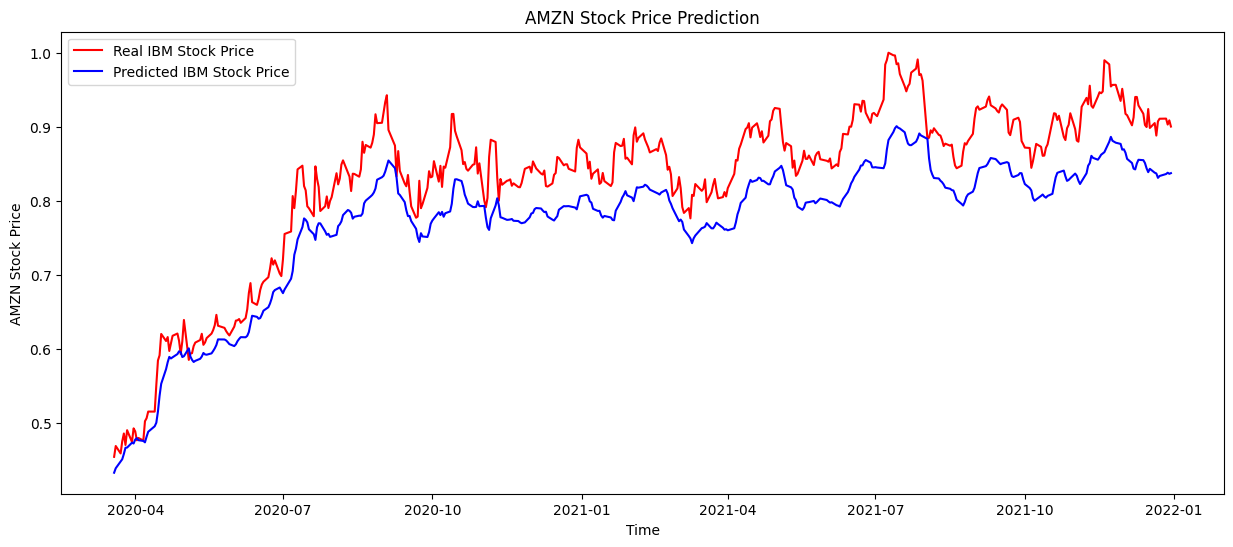

In [34]:
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.007500608824365803
Epoch  1 MSE:  0.00019799307746756027
Epoch  2 MSE:  0.00017937227087378758
Epoch  3 MSE:  0.00017852853575038208
Epoch  4 MSE:  0.0002298826185132815
Epoch  5 MSE:  0.00011537338049923787
Epoch  6 MSE:  0.00011884156554898302
Epoch  7 MSE:  0.0001137800451559949
Epoch  8 MSE:  0.0001027435253873639
Epoch  9 MSE:  0.00012531327971182212
Training time: 1.3623528480529785


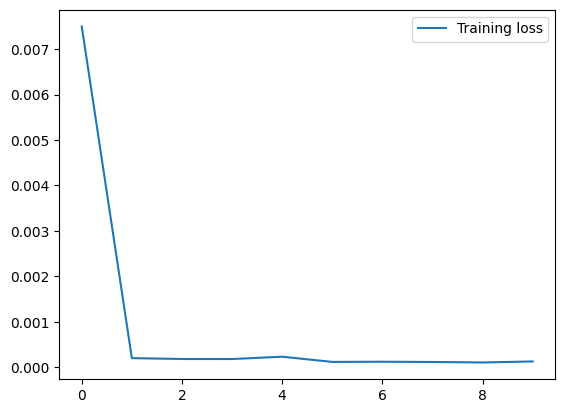

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.008268112316727638


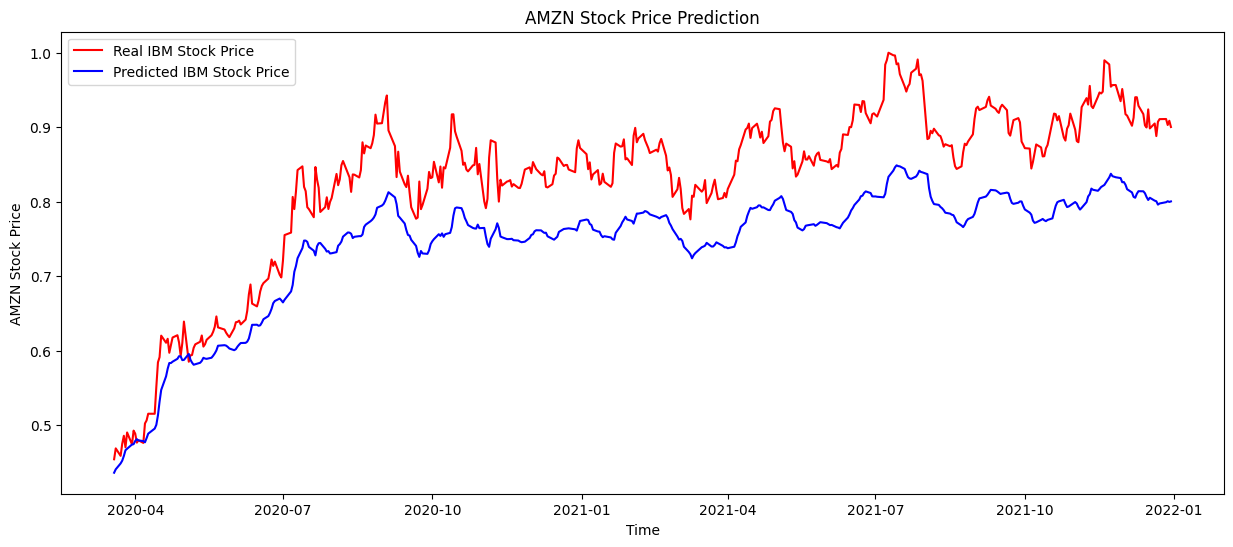

In [46]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.01034125317662409
Epoch  1 MSE:  0.00024735540328516724
Epoch  2 MSE:  0.0002313000096891253
Epoch  3 MSE:  0.0002683370288842094
Epoch  4 MSE:  0.00022408119983945079
Epoch  5 MSE:  0.00026844476389286634
Epoch  6 MSE:  0.00017599093340131251
Epoch  7 MSE:  0.0001805221948799092
Epoch  8 MSE:  0.0001659175209409257
Epoch  9 MSE:  0.0001851179706710881
Training time: 2.9010491371154785


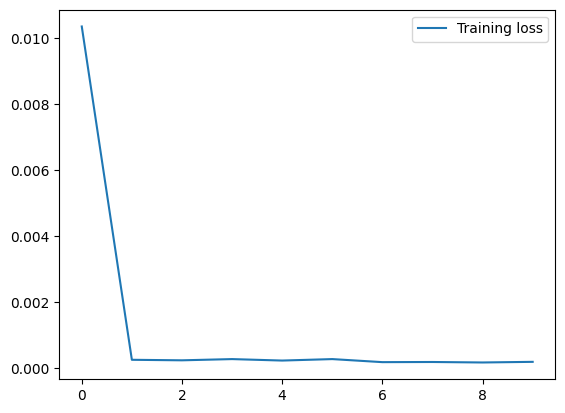

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.03610849753022194


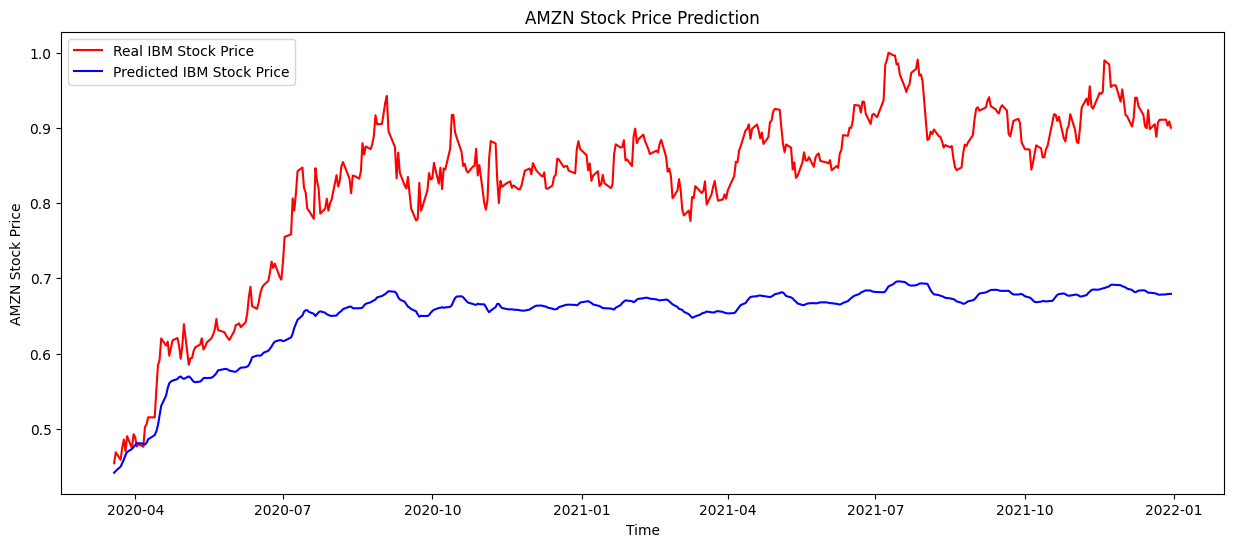

In [52]:
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.00576741040640627
Epoch  1 MSE:  9.65886508047812e-05
Epoch  2 MSE:  0.00010065435976445627
Epoch  3 MSE:  7.806043023313243e-05
Epoch  4 MSE:  7.227663225325829e-05
Epoch  5 MSE:  0.00010612893751577328
Epoch  6 MSE:  6.531884678464082e-05
Epoch  7 MSE:  0.00011314251412386511
Epoch  8 MSE:  9.685847901078217e-05
Epoch  9 MSE:  5.7751981988698584e-05
Training time: 2.6933000087738037


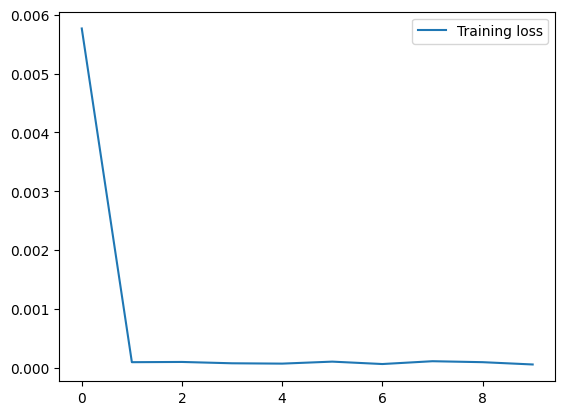

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.0023241573944687843


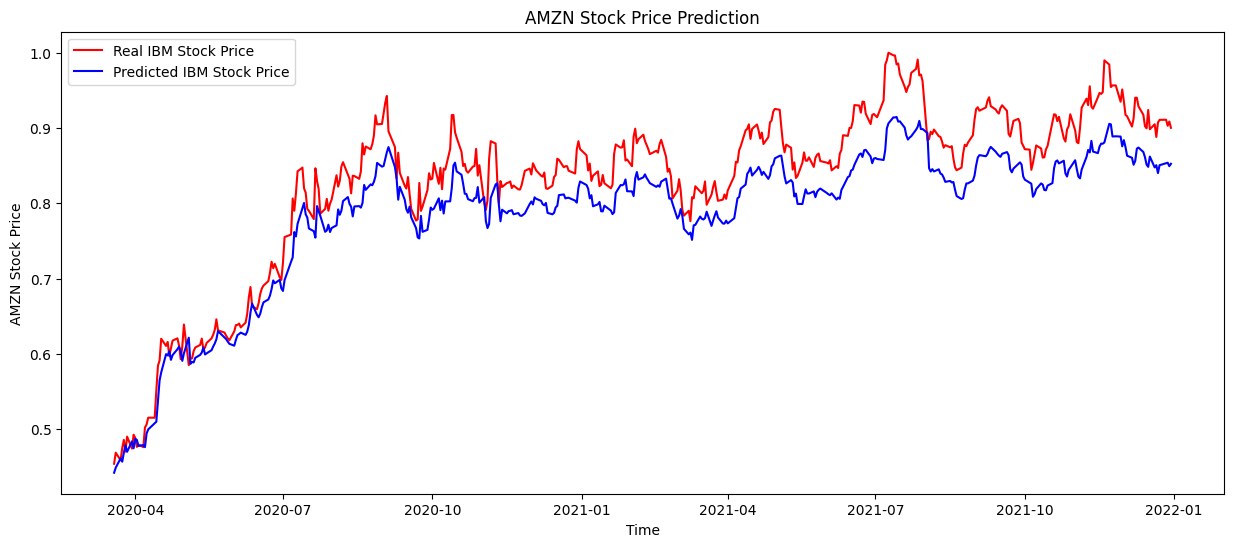

In [75]:
# lstm bidirectional
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = LSTM_v2(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.5034995703516822
Epoch  1 MSE:  0.040800954932101854
Epoch  2 MSE:  0.017596258071104164
Epoch  3 MSE:  0.009683046753420249
Epoch  4 MSE:  0.0023577461558345115
Epoch  5 MSE:  0.00034624325273494163
Epoch  6 MSE:  0.00024144482272516287
Epoch  7 MSE:  0.00020559572869004975
Epoch  8 MSE:  0.00018433026539959858
Epoch  9 MSE:  0.0001672237300035225
Training time: 0.5906257629394531


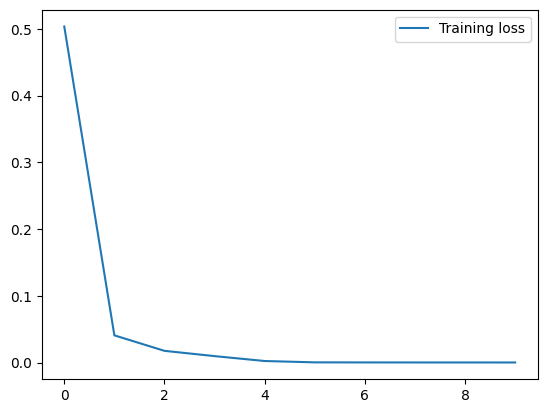

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.09223545342683792


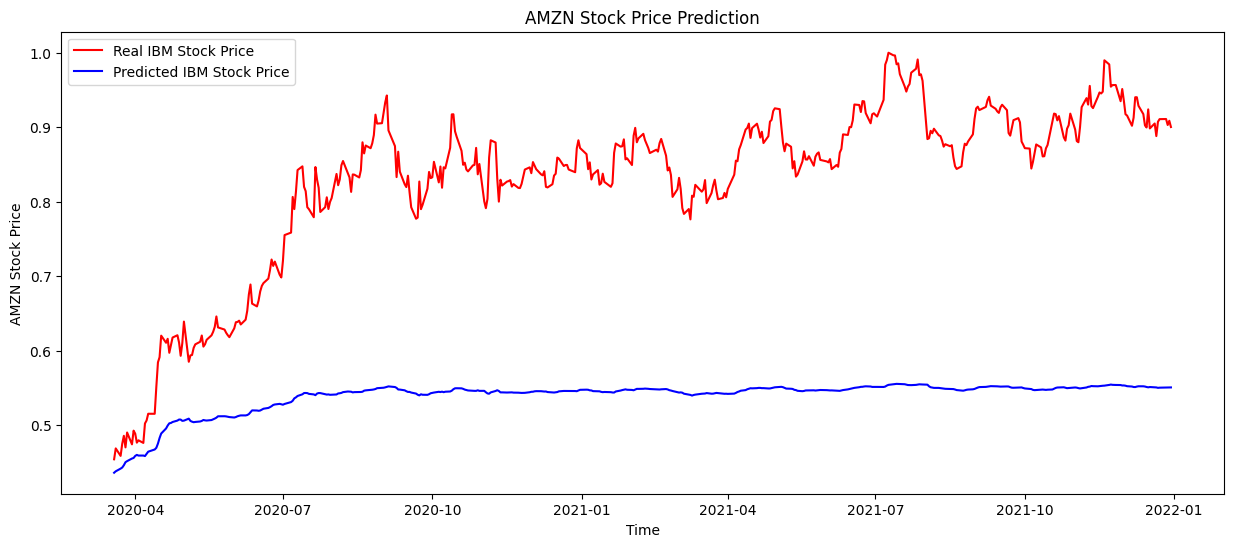

In [38]:
# vanilla gru
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.0048269798170454846
Epoch  1 MSE:  7.011910654335607e-05
Epoch  2 MSE:  5.814531092303361e-05
Epoch  3 MSE:  6.677781474488591e-05
Epoch  4 MSE:  5.887886934368381e-05
Epoch  5 MSE:  6.48034531303366e-05
Epoch  6 MSE:  6.354272679680817e-05
Epoch  7 MSE:  5.550526961877423e-05
Epoch  8 MSE:  6.368323961157187e-05
Epoch  9 MSE:  5.321404977932712e-05
Training time: 0.7587587833404541


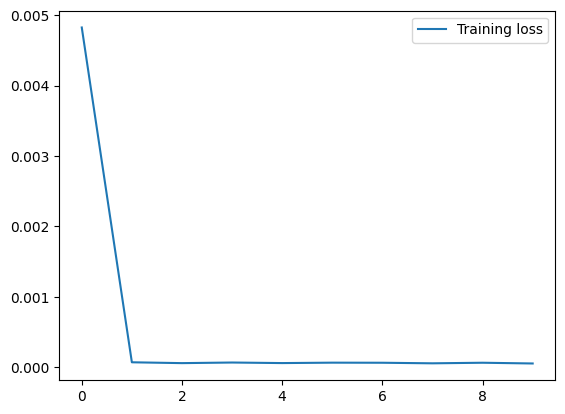

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.0010767405619844794


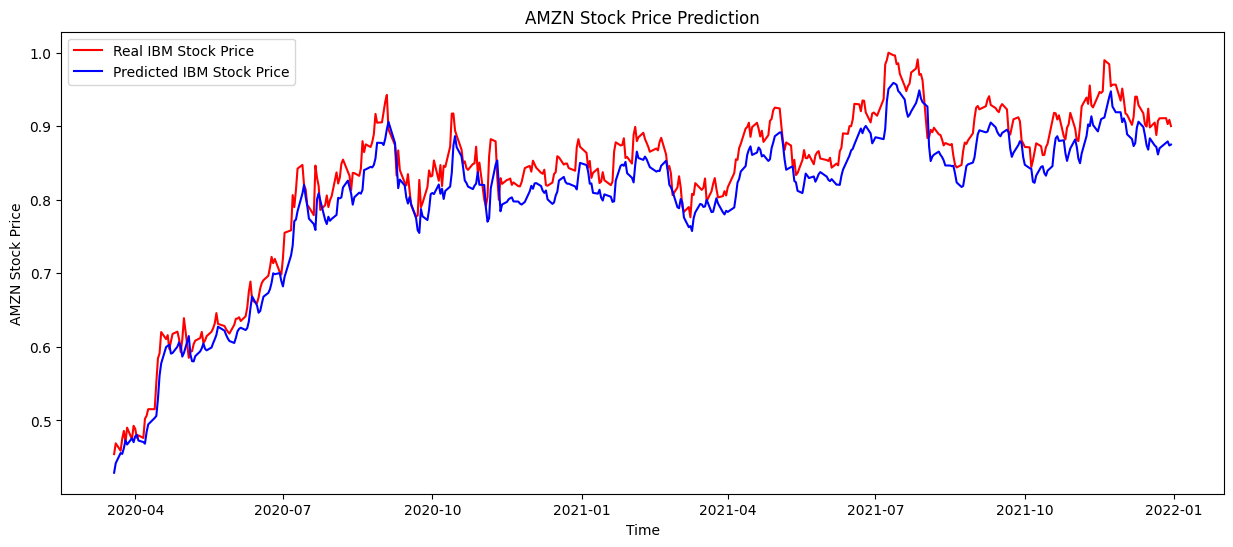

In [39]:
# gru with 32 hidd
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.006026252323289028
Epoch  1 MSE:  8.896130205022545e-05
Epoch  2 MSE:  0.0001094799706008512
Epoch  3 MSE:  8.868622309197043e-05
Epoch  4 MSE:  9.342182788953466e-05
Epoch  5 MSE:  9.089850817345953e-05
Epoch  6 MSE:  7.210157321567654e-05
Epoch  7 MSE:  9.079699298366138e-05
Epoch  8 MSE:  7.285933199191756e-05
Epoch  9 MSE:  5.6834175941395715e-05
Training time: 1.3671460151672363


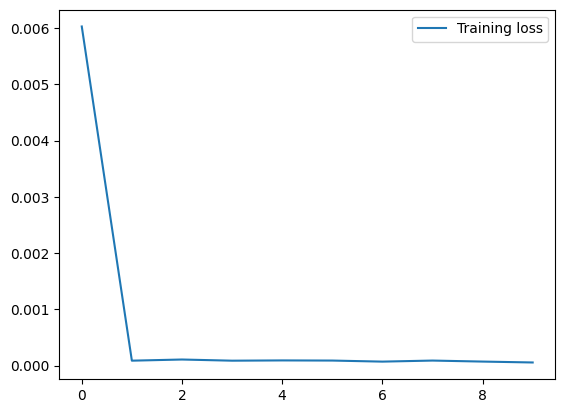

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.0023491664323955774


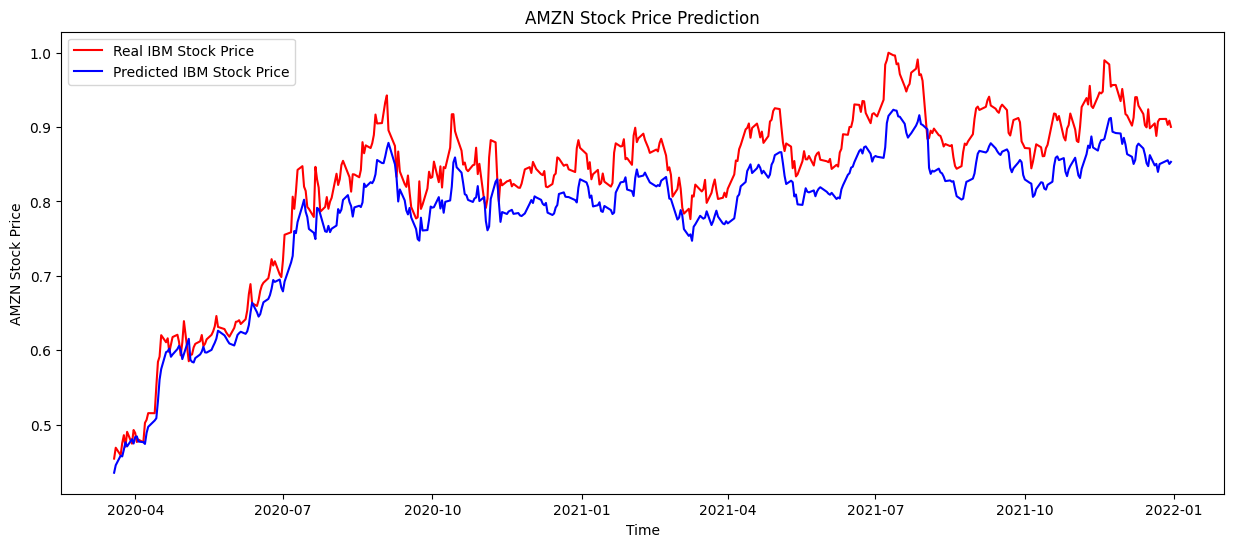

In [40]:
# gru with 2 GRU
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.009910309147352038
Epoch  1 MSE:  0.00021754566463833295
Epoch  2 MSE:  0.0002938167134217158
Epoch  3 MSE:  0.00021526909219909087
Epoch  4 MSE:  0.00018297585744987468
Epoch  5 MSE:  0.00014660057085118177
Epoch  6 MSE:  0.0003209148446306867
Epoch  7 MSE:  0.00010260101371865236
Epoch  8 MSE:  7.869103233372841e-05
Epoch  9 MSE:  8.805637662590016e-05
Training time: 2.5484561920166016


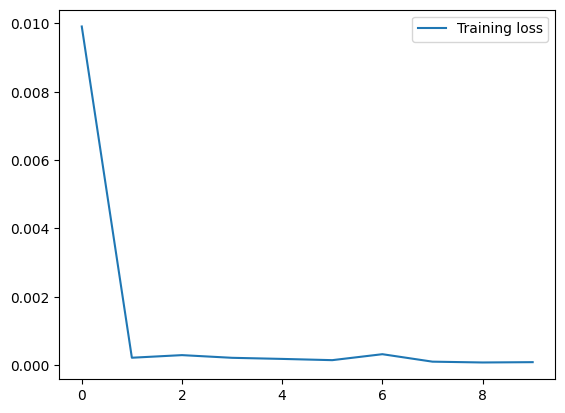

torch.Size([451, 1])
torch.Size([451, 1])
Test loss 0.01730847917497158


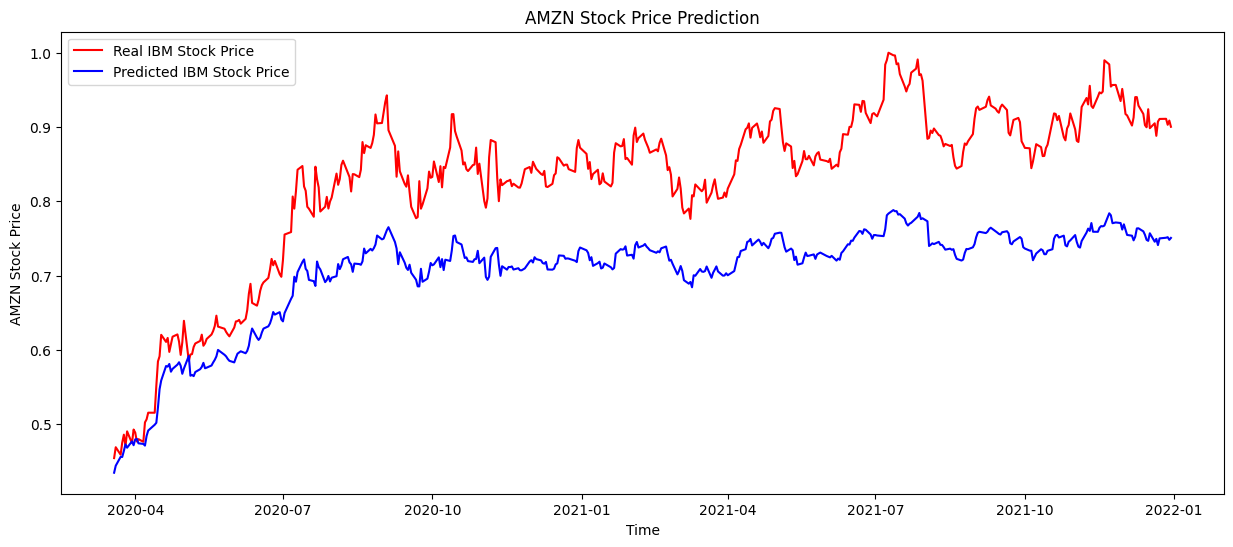

In [41]:
# gru with 4 gru
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.005249378252014987
Epoch  1 MSE:  5.146871373579241e-05
Epoch  2 MSE:  5.9727390155424237e-05
Epoch  3 MSE:  5.858213143417817e-05
Epoch  4 MSE:  5.2375389234478225e-05
Epoch  5 MSE:  7.19956160039196e-05
Epoch  6 MSE:  0.00012075380568167518
Epoch  7 MSE:  8.889619503824091e-05
Epoch  8 MSE:  8.217088633164291e-05
Epoch  9 MSE:  9.466908821893525e-05
Training time: 25.55780601501465


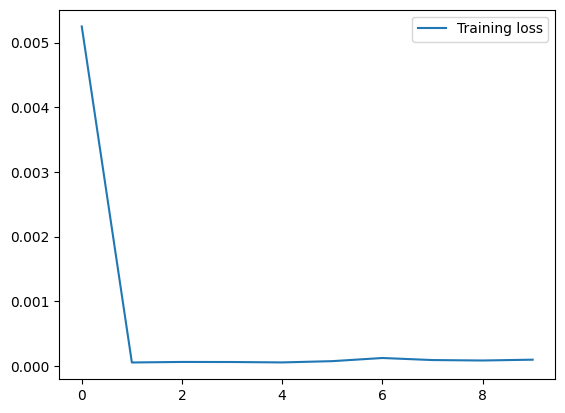

Test loss 0.0009612358990125358


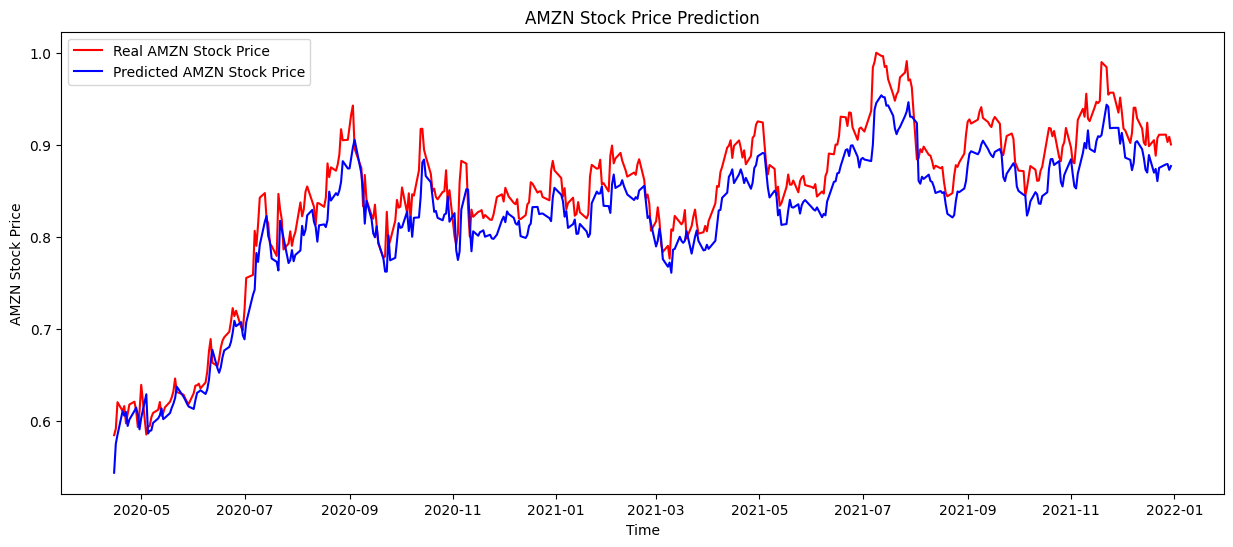

In [13]:
# gru bi
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.008988523641388906
Epoch  1 MSE:  6.776957809350977e-05
Epoch  2 MSE:  6.728182410220703e-05
Epoch  3 MSE:  5.345113738121031e-05
Epoch  4 MSE:  5.856169157795355e-05
Epoch  5 MSE:  5.1229107406445656e-05
Epoch  6 MSE:  5.8361222017245455e-05
Epoch  7 MSE:  5.246055945762025e-05
Epoch  8 MSE:  6.975429402688225e-05
Epoch  9 MSE:  7.473917860944024e-05
Training time: 25.24659776687622


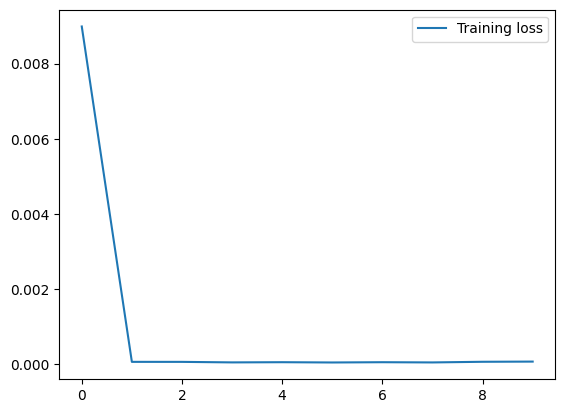

Test loss 0.0017665534978732467


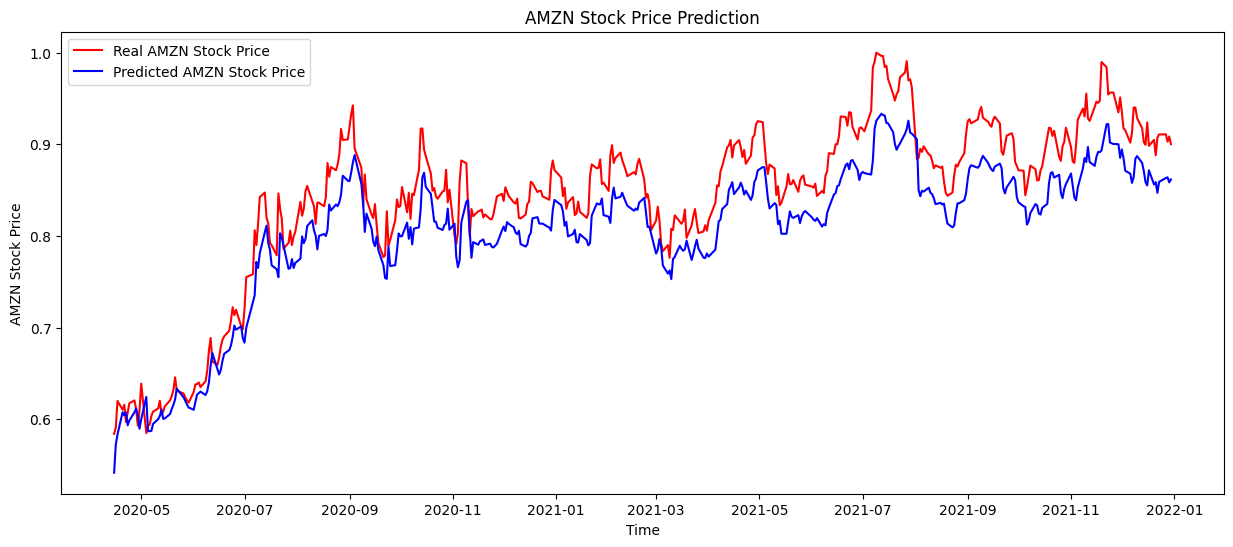

In [26]:
# GRU bidirectonal with 100 timestep
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.016644794582022508
Epoch  1 MSE:  0.00016755911197733814
Epoch  2 MSE:  8.41847479696049e-05
Epoch  3 MSE:  7.422548153717549e-05
Epoch  4 MSE:  7.577866097263934e-05
Epoch  5 MSE:  7.148139491320064e-05
Epoch  6 MSE:  7.966076775542891e-05
Epoch  7 MSE:  6.456084514093786e-05
Epoch  8 MSE:  6.60097103307585e-05
Epoch  9 MSE:  6.715817628539971e-05
Training time: 25.398212909698486


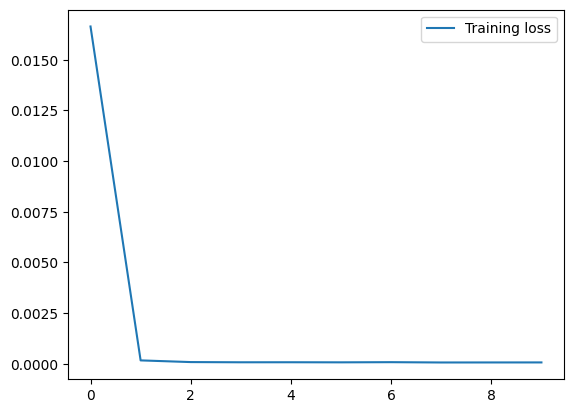

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.0014972144272178411


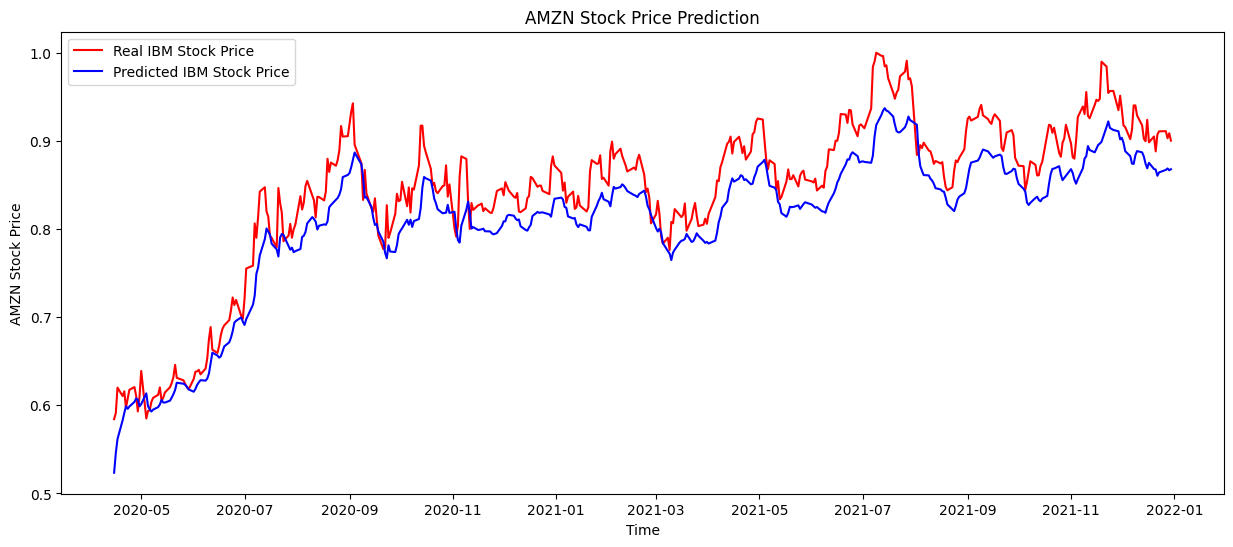

In [97]:
# GRU bidirectonal with 100 timestep, lower lr
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.3493773051025665
Epoch  1 MSE:  0.001560173431580427
Epoch  2 MSE:  0.0006800883707561696
Epoch  3 MSE:  0.0007968698043180055
Epoch  4 MSE:  0.0004778413688293531
Epoch  5 MSE:  0.0006297906180058306
Epoch  6 MSE:  0.00057801970625368
Epoch  7 MSE:  0.00048368238201699766
Epoch  8 MSE:  0.0005869840287518917
Epoch  9 MSE:  0.0015317746118143239
Training time: 25.673383951187134


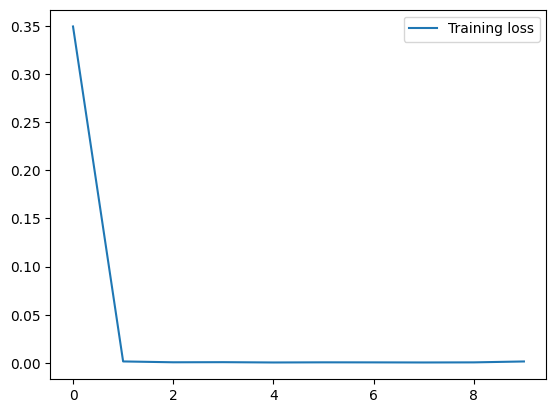

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.0067878542467951775


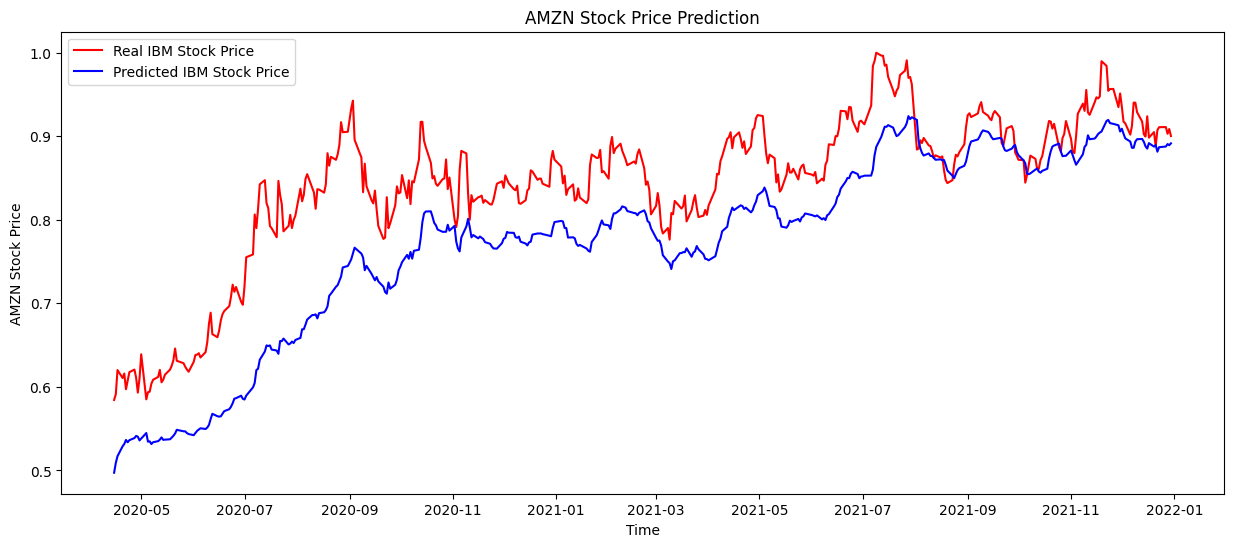

In [98]:
# GRU bidirectonal with 100 timestep, higher lr
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.004868587174264763
Epoch  1 MSE:  5.321128621090631e-05
Epoch  2 MSE:  6.805341931732534e-05
Epoch  3 MSE:  5.597513468460856e-05
Epoch  4 MSE:  6.182985608163968e-05
Epoch  5 MSE:  7.190475314753912e-05
Epoch  6 MSE:  6.681001408875614e-05
Epoch  7 MSE:  9.663131940003153e-05
Epoch  8 MSE:  9.73213683795471e-05
Epoch  9 MSE:  8.950003321431673e-05
Training time: 25.318293809890747


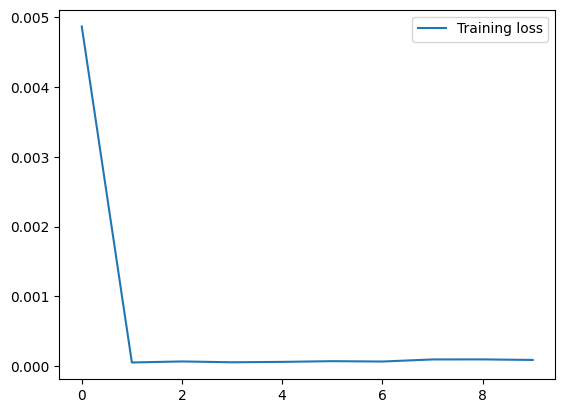

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.00389763992279768


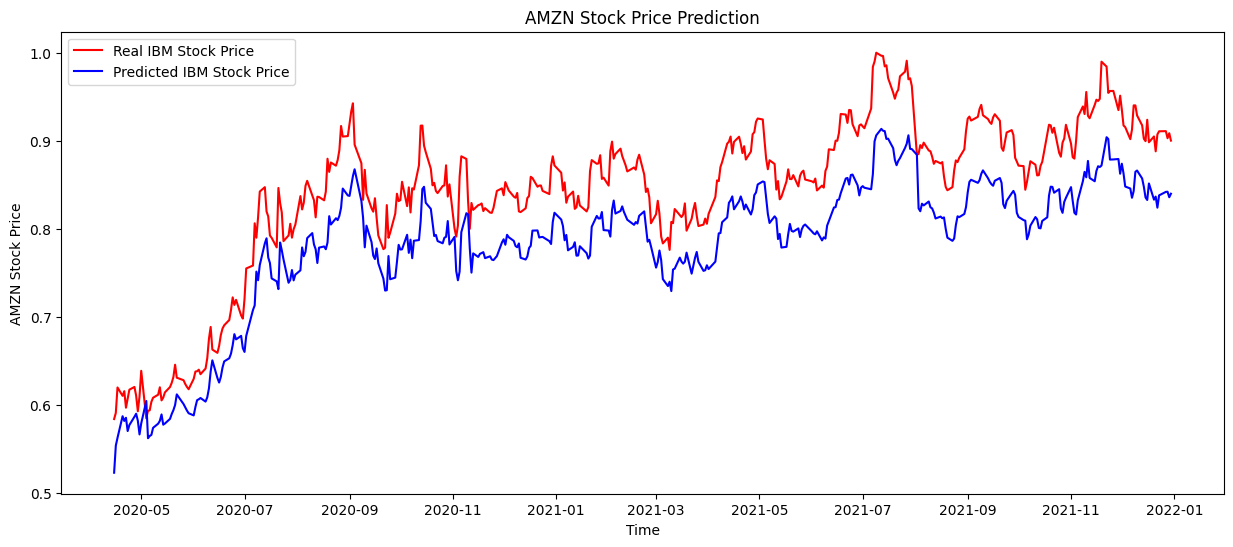

In [99]:
# GRU bidirectonal with 100 timestep , adamW and weight decay
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=4e-5)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

## Multivariate Time Series Forecasting

In [100]:
dataset_multi = dataset[['Open', 'High', 'Low', 'Close']]
dataset_multi

,Open,High,Low,Close
Date,,,,
2013-01-02,12.80,12.90,12.66,12.87
2013-01-03,12.86,13.04,12.82,12.92
2013-01-04,12.88,12.99,12.83,12.96
2013-01-07,13.15,13.49,13.13,13.42
2013-01-08,13.35,13.45,13.18,13.32
...,...,...,...,...
2021-12-23,170.43,171.98,170.15,171.07
2021-12-27,171.04,172.94,169.22,169.67
2021-12-28,170.18,172.18,169.14,170.66


In [101]:
sc = MinMaxScaler(feature_range=(0,1))
dataset_multi_scaled = sc.fit_transform(dataset_multi.values)

In [102]:
dataset_multi_scaled.shape

(2266, 4)

In [107]:
dataset_multi_scaled = np.array(dataset_multi_scaled)

data = []
time_step = 100
# create all possible sequences of length look_back
for index in range(len(dataset_multi_scaled) - time_step): 
    data.append(dataset_multi_scaled[index: index + time_step])

data = np.array(data)
# test_timestamps = np.array(test_timestamps)

test_size = int(np.round(0.2*data.shape[0]))
train_size = data.shape[0] - (test_size)
print(test_size)

X_train = data[:train_size,:-1,:]
y_train = data[:train_size,-1,-1].reshape(-1,1)

X_test = data[train_size:,:-1]
y_test = data[train_size:,-1,-1].reshape(-1,1)

433


In [108]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)


X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batch_size = 24
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [ ]:
y_test.shape

Epoch  0 MSE:  0.011649539209641149
Epoch  1 MSE:  6.245019789250912e-05
Epoch  2 MSE:  5.9610514903372496e-05
Epoch  3 MSE:  5.935465909316594e-05
Epoch  4 MSE:  5.924849373925149e-05
Epoch  5 MSE:  5.715029972833852e-05
Epoch  6 MSE:  5.9589122753245084e-05
Epoch  7 MSE:  5.84958022406918e-05
Epoch  8 MSE:  5.805686340278193e-05
Epoch  9 MSE:  7.280497393117937e-05
Epoch  10 MSE:  6.75965702113949e-05
Epoch  11 MSE:  7.405503820586066e-05
Epoch  12 MSE:  5.9102935192142514e-05
Epoch  13 MSE:  7.261483300033134e-05
Epoch  14 MSE:  5.660657426195852e-05
Epoch  15 MSE:  5.921500578302609e-05
Epoch  16 MSE:  5.991059574688273e-05
Epoch  17 MSE:  7.820044701263327e-05
Epoch  18 MSE:  7.315068587434338e-05
Epoch  19 MSE:  9.272592027104709e-05
Epoch  20 MSE:  7.824233879334428e-05
Epoch  21 MSE:  0.00010267777737407077
Epoch  22 MSE:  6.939097725641148e-05
Epoch  23 MSE:  7.77217011738984e-05
Epoch  24 MSE:  6.769409653677267e-05
Epoch  25 MSE:  9.838457511138324e-05
Epoch  26 MSE:  7.8758

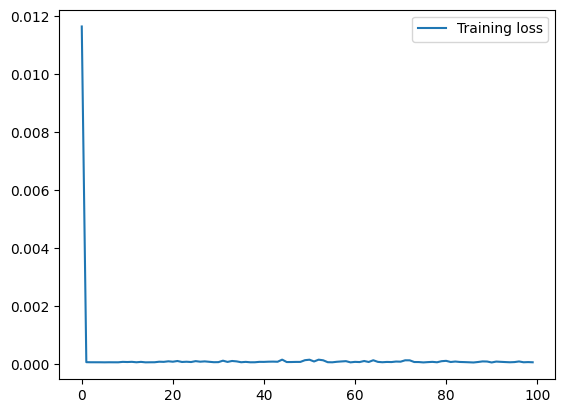

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.032050229609012604


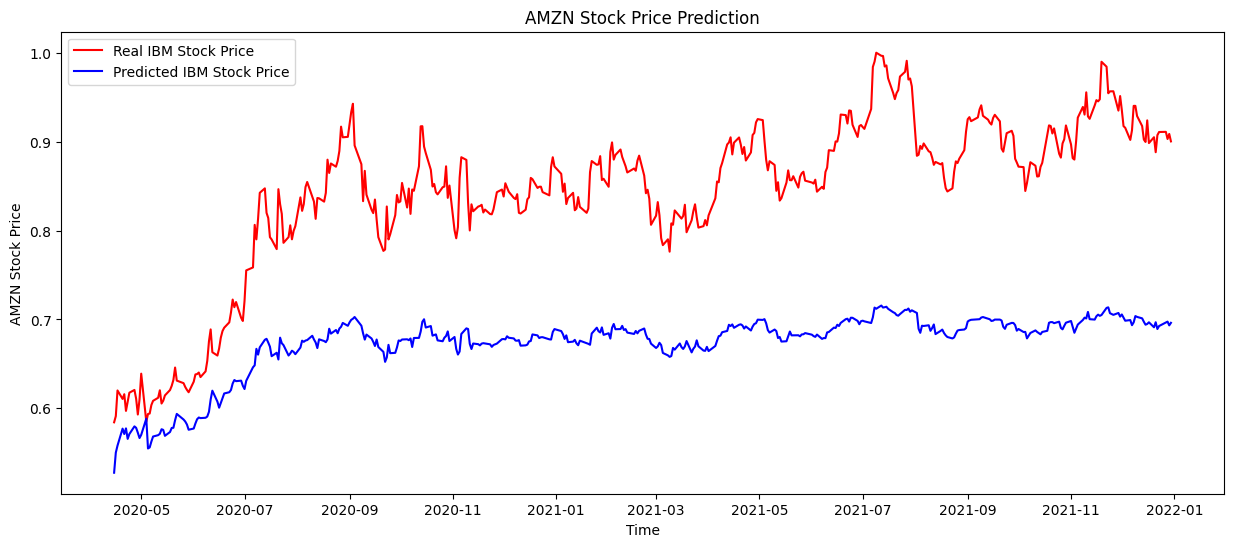

In [111]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = RNN_bi(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.0032664060643782414
Epoch  1 MSE:  0.00012122408216247057
Epoch  2 MSE:  7.627550384973827e-05
Epoch  3 MSE:  8.242173811445915e-05
Epoch  4 MSE:  7.485950882006389e-05
Epoch  5 MSE:  7.315093924960023e-05
Epoch  6 MSE:  7.387716583526862e-05
Epoch  7 MSE:  9.251279936182833e-05
Epoch  8 MSE:  0.00014718673222364174
Epoch  9 MSE:  7.340094442989626e-05
Epoch  10 MSE:  8.093587473000572e-05
Epoch  11 MSE:  6.630645829355759e-05
Epoch  12 MSE:  7.440068640964255e-05
Epoch  13 MSE:  0.00019676753797521335
Epoch  14 MSE:  7.277249789370977e-05
Epoch  15 MSE:  5.644128400926504e-05
Epoch  16 MSE:  9.018542171249203e-05
Epoch  17 MSE:  8.256661893850933e-05
Epoch  18 MSE:  6.243726600537417e-05
Epoch  19 MSE:  6.40965007645818e-05
Epoch  20 MSE:  7.318776237273234e-05
Epoch  21 MSE:  0.00010348039609509638
Epoch  22 MSE:  6.107419766808624e-05
Epoch  23 MSE:  7.525231497822137e-05
Epoch  24 MSE:  6.501617773297667e-05
Epoch  25 MSE:  6.334944195359267e-05
Epoch  26 MSE:  6.9

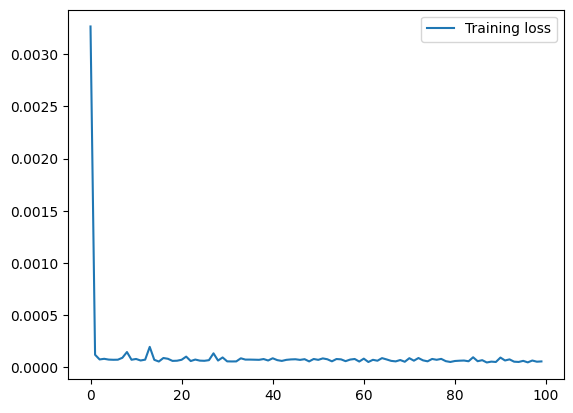

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.00854709092527628


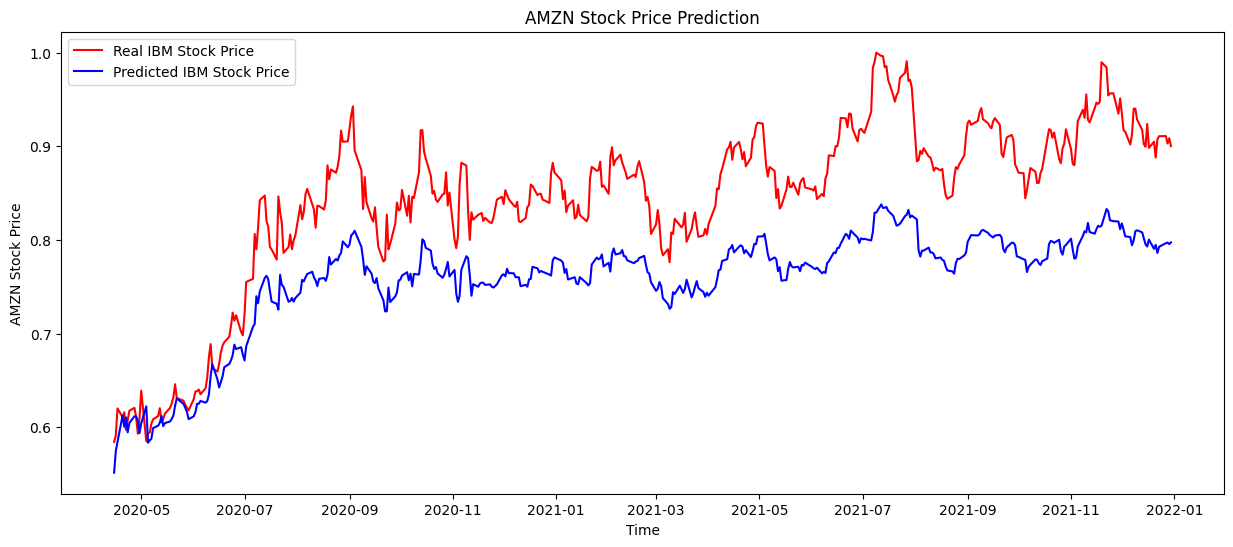

In [109]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM_v2(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.005275973133866999
Epoch  1 MSE:  7.144560724355708e-05
Epoch  2 MSE:  5.6803035576730545e-05
Epoch  3 MSE:  6.045451336582143e-05
Epoch  4 MSE:  5.9756090456786506e-05
Epoch  5 MSE:  7.86773492931488e-05
Epoch  6 MSE:  5.814162785112511e-05
Epoch  7 MSE:  8.920962188798736e-05
Epoch  8 MSE:  5.9760485957468355e-05
Epoch  9 MSE:  6.145281630069056e-05
Epoch  10 MSE:  6.0031236363064546e-05
Epoch  11 MSE:  6.471574781169518e-05
Epoch  12 MSE:  7.86478754790015e-05
Epoch  13 MSE:  6.767131402465229e-05
Epoch  14 MSE:  8.535453700261152e-05
Epoch  15 MSE:  7.048033946114018e-05
Epoch  16 MSE:  0.00011331220760950277
Epoch  17 MSE:  7.810191586380426e-05
Epoch  18 MSE:  6.337001219460397e-05
Epoch  19 MSE:  8.798368786575675e-05
Epoch  20 MSE:  0.0001304024817104681
Epoch  21 MSE:  7.80702487907248e-05
Epoch  22 MSE:  8.235151618427066e-05
Epoch  23 MSE:  0.00012045076836367203
Epoch  24 MSE:  0.00010139776948139339
Epoch  25 MSE:  7.843615535358828e-05
Epoch  26 MSE:  5.9

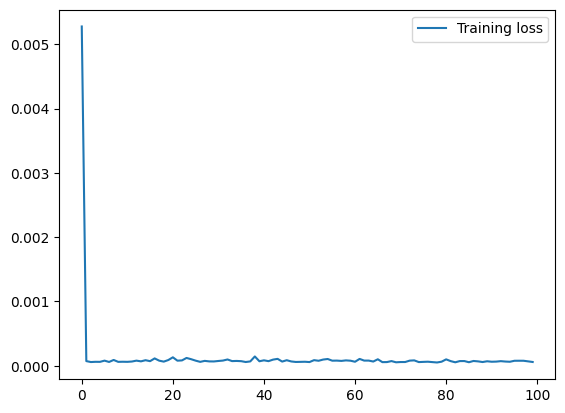

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.012409016489982605


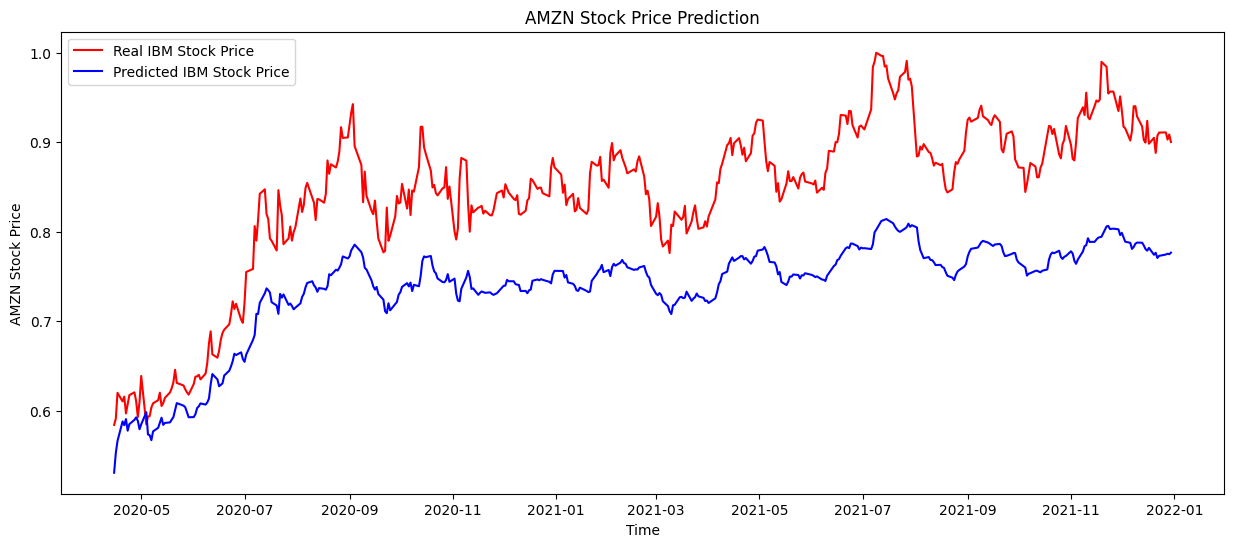

In [112]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

<AxesSubplot: xlabel='Date'>

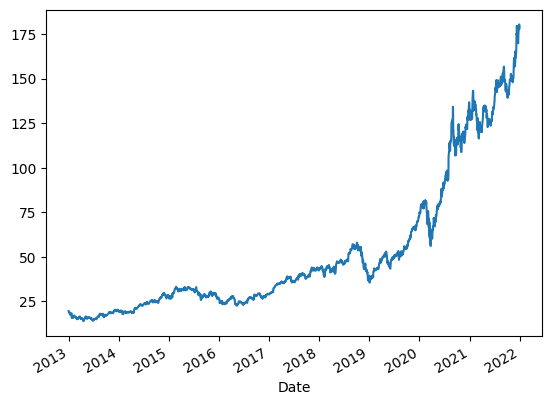

In [113]:
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_amzn = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
GOOG = yf.download('GOOG', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_GOOG = GOOG[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
MSFT = yf.download('MSFT', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_MSFT = MSFT[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
AAPL = yf.download('AAPL', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_AAPL = AAPL[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
dataset_AAPL.head(10)
dataset_AAPL['Close'].plot()

In [124]:
dataset_amzn.rename(columns={'Close':'AMZN'},inplace=True)

dataset_close=dataset_amzn[['AMZN']]
dataset_close['GOOG']=dataset_GOOG['Close']
dataset_close['MSFT']=dataset_MSFT['Close']
dataset_close['AAPL']=dataset_AAPL['Close']
dataset_close

/var/folders/bk/sj8dwg9d73vb0r56r8k9md280000gn/T/ipykernel_35816/1315785748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_close['GOOG']=dataset_GOOG['Close']
/var/folders/bk/sj8dwg9d73vb0r56r8k9md280000gn/T/ipykernel_35816/1315785748.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_close['MSFT']=dataset_MSFT['Close']
/var/folders/bk/sj8dwg9d73vb0r56r8k9md280000gn/T/ipykernel_35816/1315785748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,AMZN,GOOG,MSFT,AAPL
Date,,,,
2013-01-02,12.87,18.01,27.62,19.61
2013-01-03,12.92,18.02,27.25,19.36
2013-01-04,12.96,18.38,26.74,18.82
2013-01-07,13.42,18.30,26.69,18.71
2013-01-08,13.32,18.26,26.55,18.76
...,...,...,...,...
2021-12-23,171.07,147.14,334.69,176.28
2021-12-27,169.67,148.06,342.45,180.33
2021-12-28,170.66,146.45,341.25,179.29


In [125]:
sc = MinMaxScaler(feature_range=(0,1))
dataset_multi_scaled = sc.fit_transform(dataset_close.values)

In [126]:
dataset_multi_scaled = np.array(dataset_multi_scaled)

data = []
time_step = 100
# create all possible sequences of length look_back
for index in range(len(dataset_multi_scaled) - time_step): 
    data.append(dataset_multi_scaled[index: index + time_step])

data = np.array(data)
# test_timestamps = np.array(test_timestamps)

test_size = int(np.round(0.2*data.shape[0]))
train_size = data.shape[0] - (test_size)
print(test_size)

X_train = data[:train_size,:-1,:]
y_train = data[:train_size,-1,-1].reshape(-1,1)

X_test = data[train_size:,:-1]
y_test = data[train_size:,-1,-1].reshape(-1,1)

433


In [127]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)


X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batch_size = 24
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

Epoch  0 MSE:  0.007447440155274682
Epoch  1 MSE:  0.00037743153719531293
Epoch  2 MSE:  0.00010372543650578025
Epoch  3 MSE:  7.380827663251843e-05
Epoch  4 MSE:  6.202820089764491e-05
Epoch  5 MSE:  3.6715018206002105e-05
Epoch  6 MSE:  4.086466295320113e-05
Epoch  7 MSE:  5.481272769616661e-05
Epoch  8 MSE:  4.341371805659872e-05
Epoch  9 MSE:  4.666558727764561e-05
Training time: 8.980104207992554


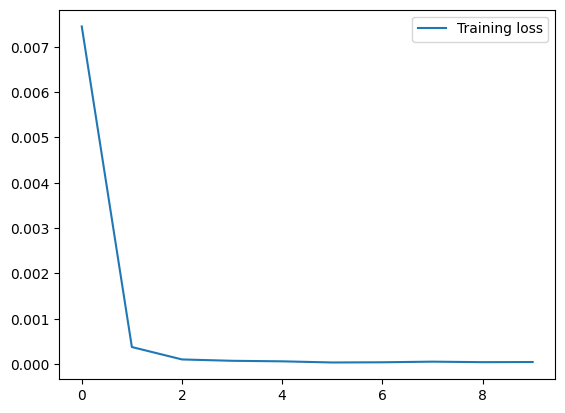

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.004925733897835016


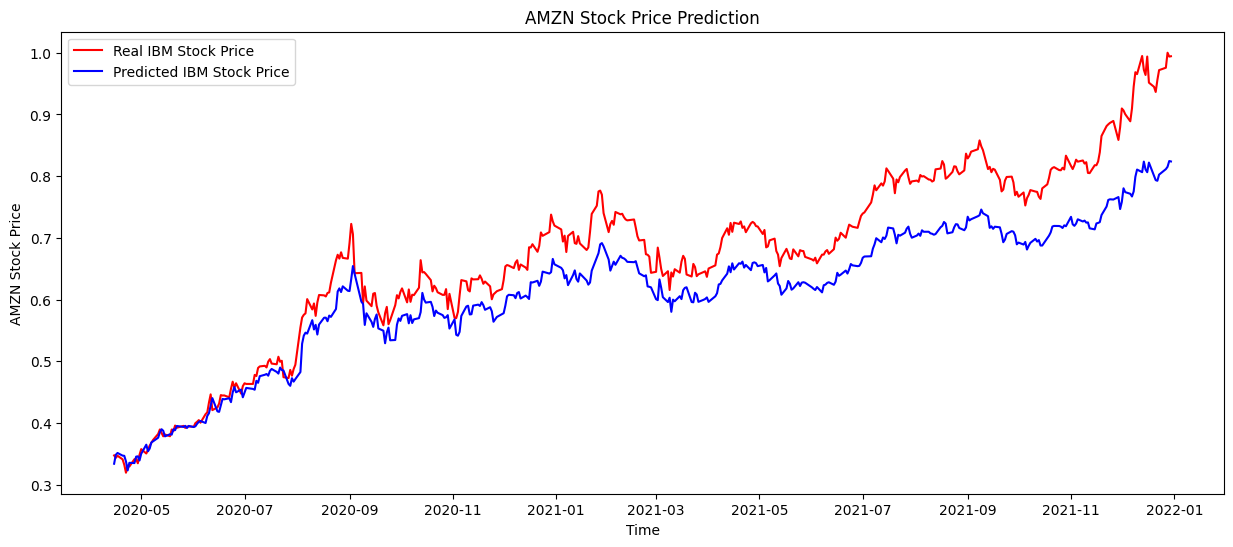

In [129]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = RNN_bi(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.0018229593541983463
Epoch  1 MSE:  0.00032359745500175514
Epoch  2 MSE:  0.00010504182127116197
Epoch  3 MSE:  6.327332461645312e-05
Epoch  4 MSE:  4.883268896152651e-05
Epoch  5 MSE:  4.857027738892126e-05
Epoch  6 MSE:  3.9679710550432265e-05
Epoch  7 MSE:  4.950113344259005e-05
Epoch  8 MSE:  3.5492112608016504e-05
Epoch  9 MSE:  4.0787396120658614e-05
Training time: 25.858726978302002


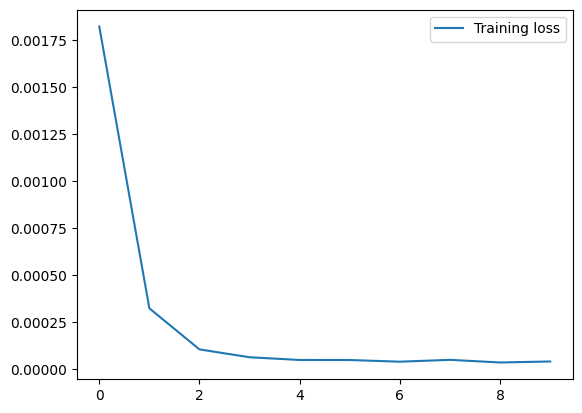

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.00435424130409956


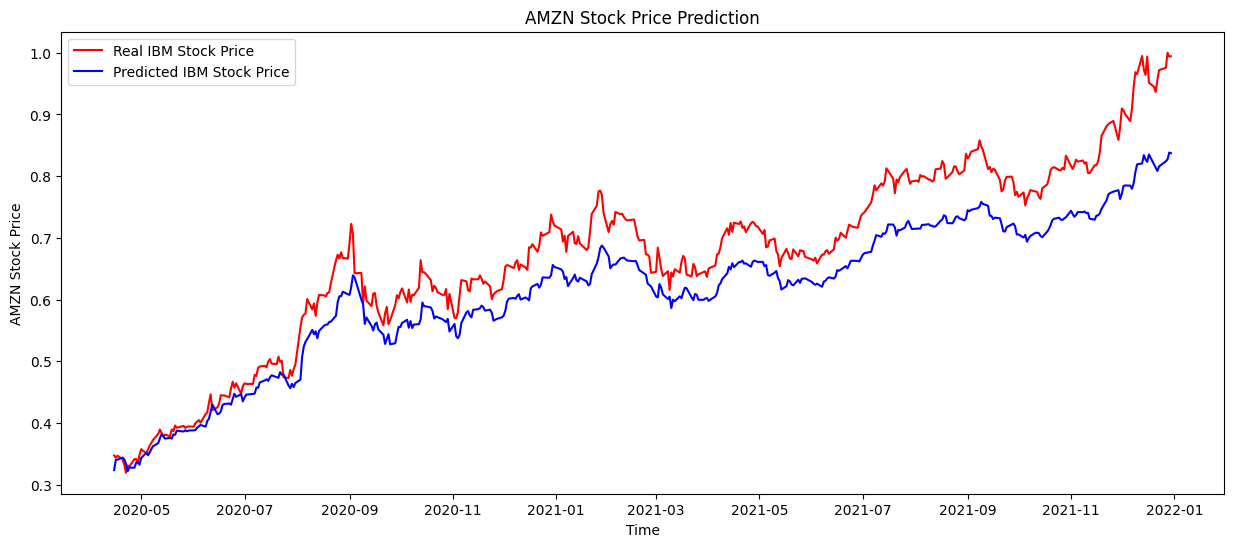

In [130]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = LSTM_v2(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.005145729311713183
Epoch  1 MSE:  0.00030035622111339864
Epoch  2 MSE:  0.00010103530397304583
Epoch  3 MSE:  8.410197047128786e-05
Epoch  4 MSE:  4.408201272644251e-05
Epoch  5 MSE:  3.988834912714282e-05
Epoch  6 MSE:  3.8703804975365565e-05
Epoch  7 MSE:  6.539668962207929e-05
Epoch  8 MSE:  4.874184235146234e-05
Epoch  9 MSE:  3.725017932208162e-05
Training time: 25.830785989761353


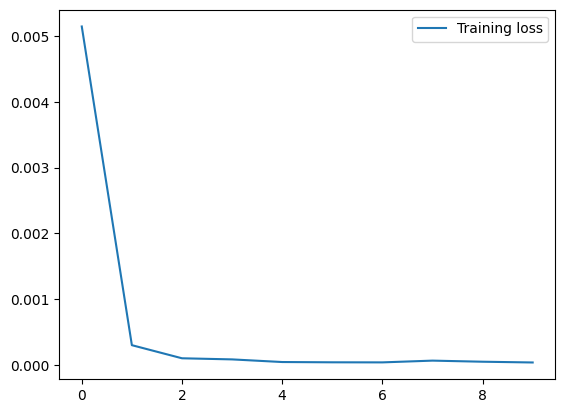

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.0046433680690824986


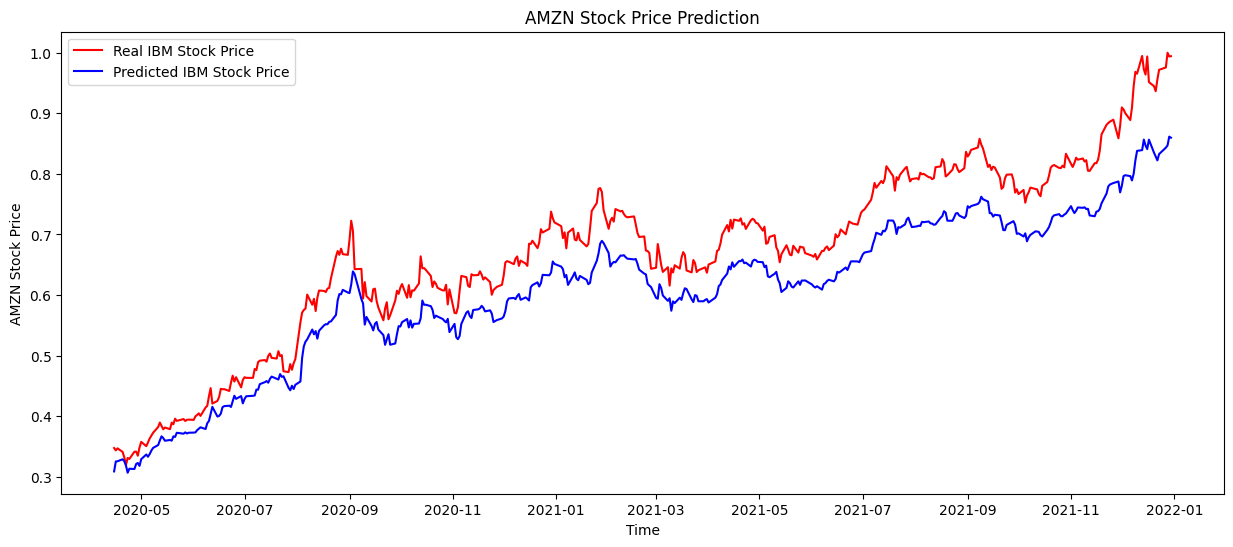

In [131]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

todo:
add other col like weatther
stacked
Bidirectional


In [ ]:
class RNN_bi(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [55]:
class LSTM_bi(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_bi, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [56]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

RuntimeError: input.size(-1) must be equal to input_size. Expected 4, got 1